# Import packages

In [3]:
import os
import sys
%matplotlib inline
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import datetime

#to set unique date for outputs
calc_date = datetime.datetime.now()
date=calc_date.strftime('%Y-%m-%d')
#date=calc_date.strftime('%d-%m-%Y')
date = date.replace('-', '')

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=300, dpi_save=300)

# input data and metadata

In [5]:
indexer = pd.read_csv('/lustre/scratch117/cellgen/team298/SharedFolders/YS_proj/Datasets/YS_datasets_indexer.csv', index_col=0)

keys = ['YS_EL','Gastrulation','Fetal_Liver','Adult_Liver', 'Clara_IPSC']

intersect_genes = False

adatas = {}
gene_intersect = []

for key in keys:
    adatas[key] = sc.read(indexer.loc[key]['Specific_Directory'])
    adatas[key].var_names_make_unique()
    adatas[key].obs['celltypes_anno'] = adatas[key].obs[indexer.loc[key]['Main_anno_col']]
    
    if len(keys) == 1:
        adata = list(adatas.values())[0].concatenate(list(adatas.values())[1:],join='inner')
        print('Only one dataset selected from indexer, dataset loaded as: adata')
        break
    
    if key == keys[0]:
        gene_intersect = list(adatas[key].var_names)
    else:
        gene_intersect = [gene for gene in list(adatas[key].var_names) if gene in gene_intersect]   #set(list1).intersection(list2)
        if key == keys[-1]:  
            print('All datasets loaded under dictionary: adatas')

            
metadata_addition = {
'Adult_Liver' : '/lustre/scratch117/cellgen/team298/SharedFolders/ar32/YS/Submission_Science_1/Indexers_for_scored_adult_hepatocytes.csv'
}

for key in metadata_addition.keys():
    additional_metadata = pd.read_csv(metadata_addition[key], index_col=0)
    for col in additional_metadata:
        adatas[key].obs[col] = 'nan'
        adatas[key].obs.loc[adatas[key].obs.index.isin(list(additional_metadata.index)), col] = additional_metadata[col].values
            
if intersect_genes == True:
    for dataset in adatas:
        adatas[dataset] = adatas[dataset][:,adatas[dataset].var_names.isin(gene_intersect)]

All datasets loaded under dictionary: adatas


In [6]:
adatas['YS_EL'].obs['celltypes_for_dotplot'] = adatas['YS_EL'].obs['broad_cell_labels_organ']
adatas['Gastrulation'].obs['celltypes_for_dotplot'] = adatas['Gastrulation'].obs['corr_concat']
adatas['Fetal_Liver'].obs['celltypes_for_dotplot'] = adatas['Fetal_Liver'].obs['cell.labels'].astype(str) + '_liver_not_matched'
adatas['Adult_Liver'].obs['celltypes_for_dotplot'] = adatas['Adult_Liver'].obs['scored_hepatocytes'].astype(str) + '_adult'
adatas['Clara_IPSC'].obs['celltypes_for_dotplot'] = adatas['Clara_IPSC'].obs['LR_assignment_v2'].astype(str)

adatas['Adult_Liver'] = adatas['Adult_Liver'][adatas['Adult_Liver'].obs['NormalvsTumor'].isin(['Normal'])]
adatas['Adult_Liver'].obs['scored_hepatocytes'] = adatas['Adult_Liver'].obs['scored_hepatocytes'].replace('nan','not_hepatocytes', regex=True)

for key in adatas:
    sc.pp.normalize_total(adatas[key], target_sum=1e4)
    sc.pp.log1p(adatas[key])
    sc.pp.scale(adatas[key], max_value = 10)

adatas['Fetal_Liver'] = adatas['Fetal_Liver'][adatas['Fetal_Liver'].obs['celltypes_anno'].isin(['Hepatocyte'])]
adatas['Adult_Liver'] = adatas['Adult_Liver'][adatas['Adult_Liver'].obs['scored_hepatocytes'].isin(['scored_hepatocytes'])] 
adatas['Clara_IPSC'] = adatas['Clara_IPSC'][adatas['Clara_IPSC'].obs['celltypes_for_dotplot'].isin(['Endoderm_IPSC'])]
    

adata_list = [adatas['YS_EL'],adatas['Gastrulation'],adatas['Fetal_Liver'],adatas['Adult_Liver'],adatas['Clara_IPSC']]
adatas['adata'] = sc.AnnData.concatenate(*adata_list, join='inner', batch_categories=None ,index_unique=None)

adatas['adata'] = adatas['adata'][adatas['adata'].obs['celltypes_for_dotplot'].isin(['YS Endoderm_Yolk Sac_gastrulation','Endoderm_YS','Hepatocyte_fliv','Hepatocyte_liver_not_matched','scored_hepatocytes_adult','Fibroblast_YS','Fibroblast_fliv','Smooth_Muscle_YS','Mesothelium_YS','Endoderm_IPSC'])]

/tmp/ipykernel_506/70593782.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adatas['Adult_Liver'].obs['scored_hepatocytes'] = adatas['Adult_Liver'].obs['scored_hepatocytes'].replace('nan','not_hepatocytes', regex=True)
/home/jovyan/my-conda-envs/YS_env/lib/python3.9/contextlib.py:124: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:01)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/jovyan/my-conda-envs/YS_env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/jovyan/my-conda-envs/YS_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


/tmp/ipykernel_506/27148991.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adatas['adata'].obs['celltypes_for_dotplot'] = adatas['adata'].obs['celltypes_for_dotplot'].astype('category')


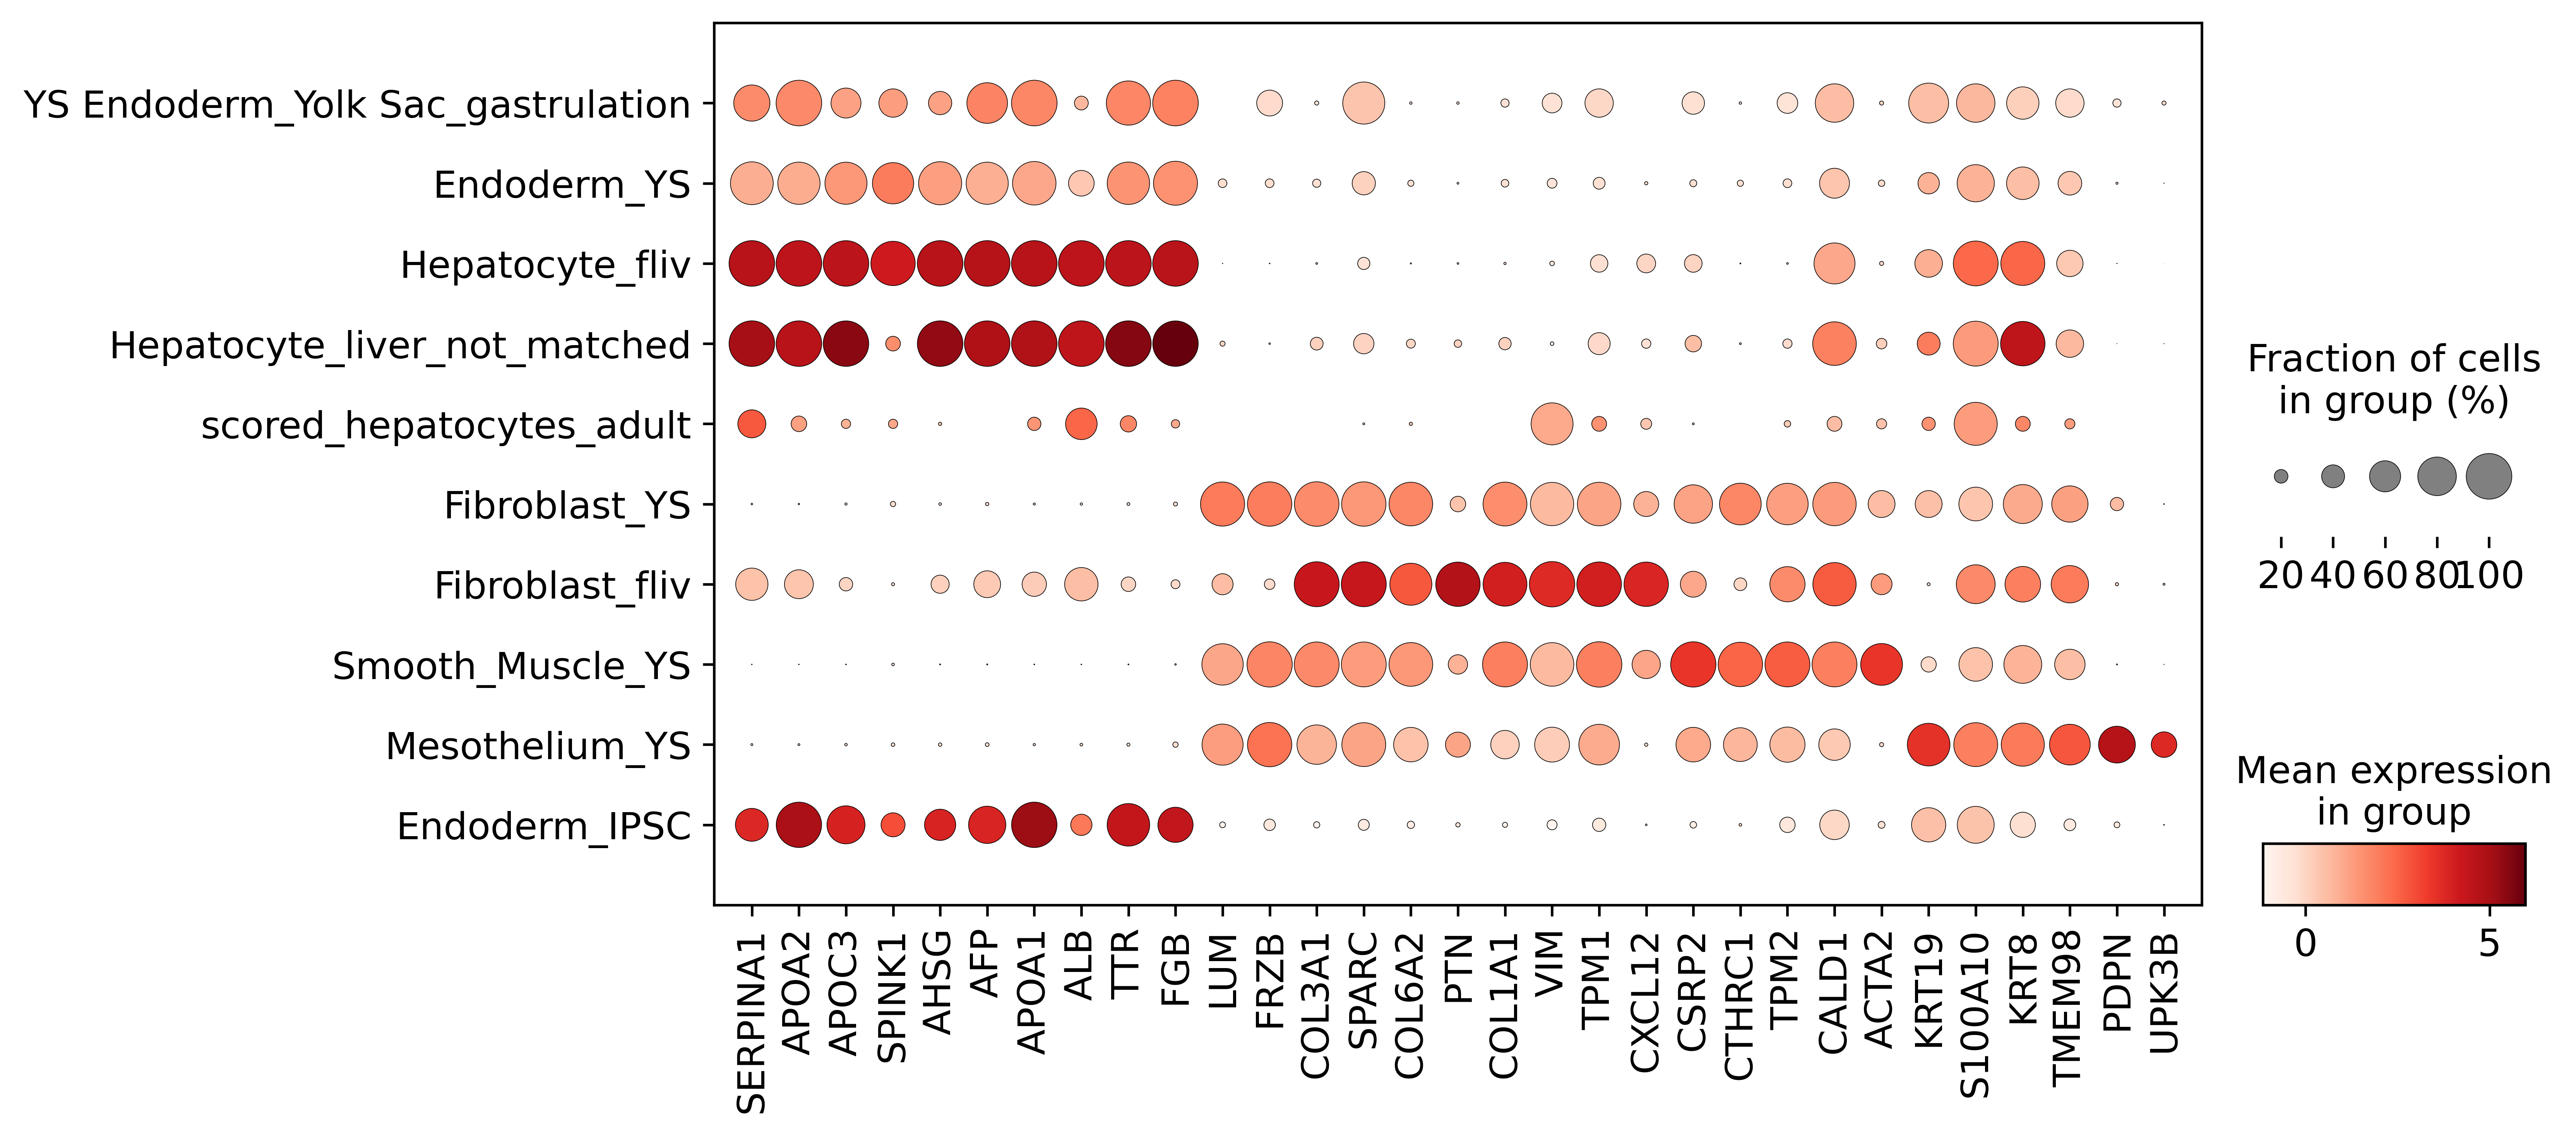

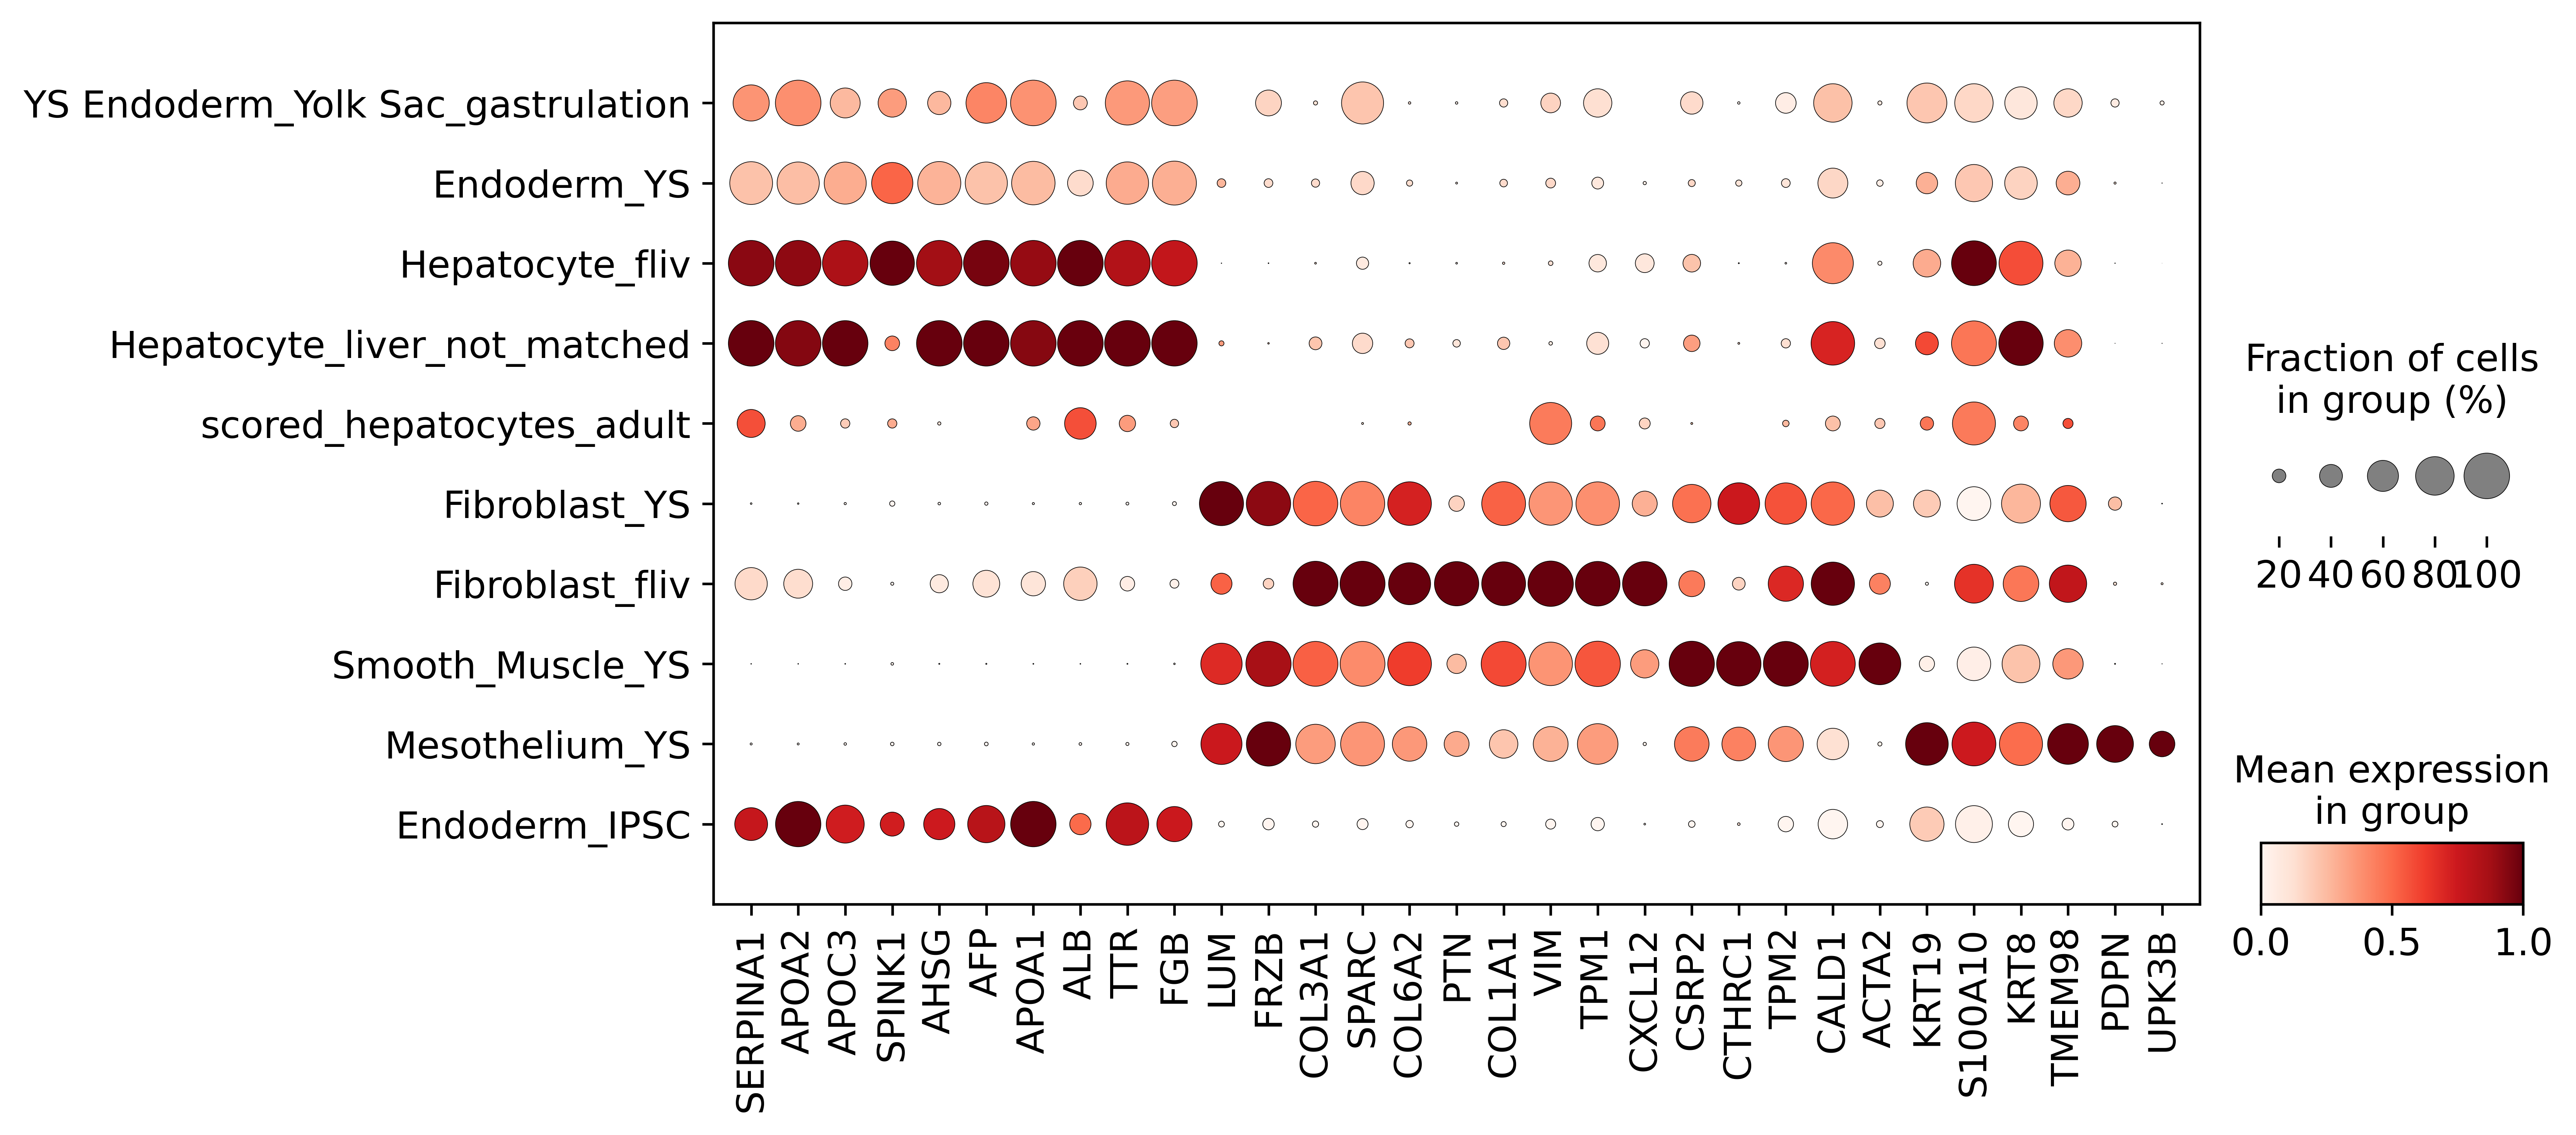

In [7]:
gene_list_plot = [
'SERPINA1',
'APOA2',
'APOC3',
'SPINK1',
'AHSG',
'AFP',
'APOA1',
'ALB',
'TTR',
'FGB',
'LUM',
'FRZB',
'COL3A1',
'SPARC',
'COL6A2',
'PTN',
'COL1A1',
'VIM',
'TPM1',
'CXCL12',
'CSRP2',
'CTHRC1',
'TPM2',
'CALD1',
'ACTA2',
'KRT19',
'S100A10',
'KRT8',
'TMEM98',
'PDPN',
'UPK3B'
]

adatas['adata'].obs['celltypes_for_dotplot'] = adatas['adata'].obs['celltypes_for_dotplot'].astype('category')
adatas['adata'].obs['celltypes_for_dotplot'] = adatas['adata'].obs['celltypes_for_dotplot'].cat.reorder_categories(['YS Endoderm_Yolk Sac_gastrulation','Endoderm_YS','Hepatocyte_fliv','Hepatocyte_liver_not_matched','scored_hepatocytes_adult','Fibroblast_YS','Fibroblast_fliv','Smooth_Muscle_YS','Mesothelium_YS','Endoderm_IPSC'])

sc.pl.dotplot(adatas['adata'], groupby= 'celltypes_for_dotplot', var_names=gene_list_plot, use_raw=False, swap_axes=False, figsize=(10,5), save='YS_main_fig2a_{d}.pdf'.format(d=date)) # save = 'fig4a_with_adult_20220310.pdf'
sc.pl.dotplot(adatas['adata'], groupby= 'celltypes_for_dotplot', var_names=gene_list_plot, use_raw=False, swap_axes=False, figsize=(10,5), standard_scale='var', save='YS_main_fig2a_standard_scale_var_{d}.pdf'.format(d=date))